# Problème n°2: PointNet

Certains jeux de données impliquent des nuages de points dans un espace 3D. Penser par exemple à un ensemble de mesures lidar : chaque tir permet de renseigner les coordonnées d'un des points de l'objet ciblé.
Une tâche intéressante consiste à classer chacun des points du nuage en fonction de l'objet auquel il appartient. Cette tâche est considérée comme une variante de la segmentation sémantique d'images.

Ce problème introduit à une méthode directe de segmentation d'un nuage par deep learning. Elle est basée sur une architecture particulière appelée PointNet. \
Dans la première partie, on présente un jeu de données (synthétisé à la volée) impliquant des nuages de points.
Dans la seconde partie, on explore la structure et les propriétés de PointNet. Dans la troisième, on l'entraîne et dans la dernière partie, on charge les poids d'une version améliorée de PointNet (PointNet++) pour comparaison.

La cellule suivante permet les imports nécessaires:

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.pyplot as plt
import os
! pip install einops
! git clone https://github.com/messagerjulien/exam_2025.git
! cp exam_2025/utils/utils_probleme2.py .
from utils_probleme2 import gen_pointcloud, plot_triplets

fatal: destination path 'exam_2025' already exists and is not an empty directory.


## Partie I : un exemple de PointCLoud data

Pour construire le jeu de données, on simule un terrain couvert de deux types de bâtiments : des immeubles de forme rectangulaire aux toits plats et des igloos (dômes). Pour créer les nuages, on échantillonne les surfaces vues du ciel (les murs des bâtiments rectangulaires ne sont pas échantillonnées), en favorisant les zones d'altitude non nulles.
Le but est de distinguer les igloos du reste (sol et toits des bâtiments). Il s'agit donc d'une segmentation binaire.

0


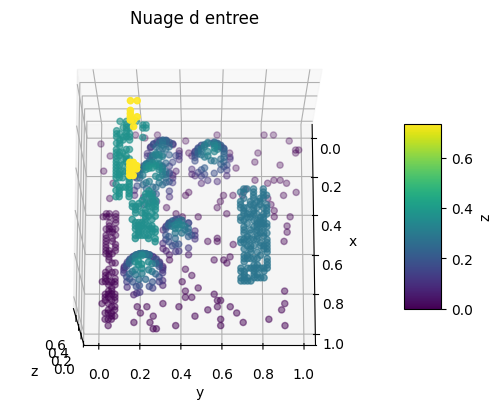

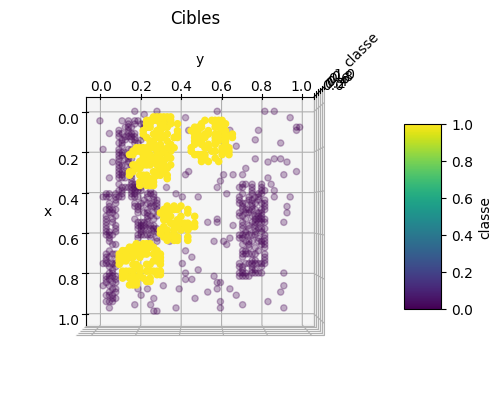

1


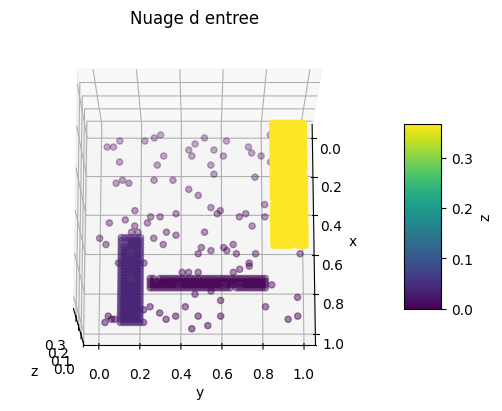

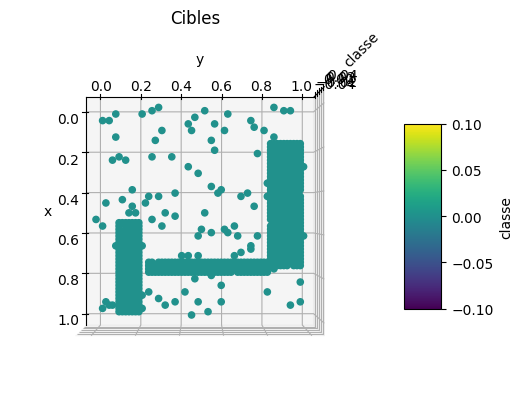

2


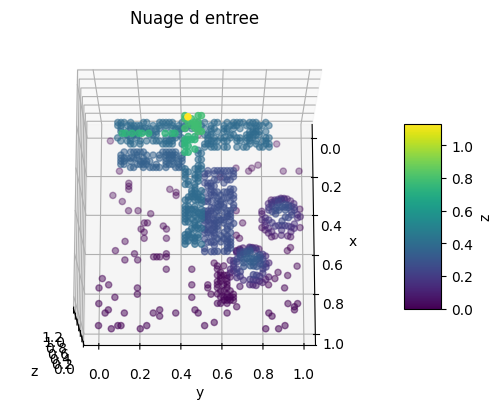

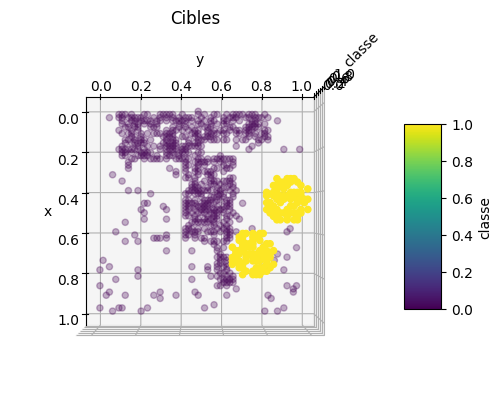

3


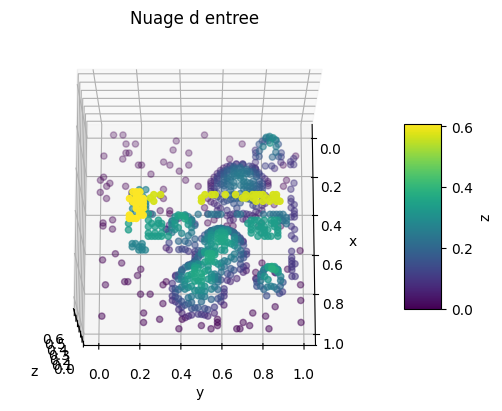

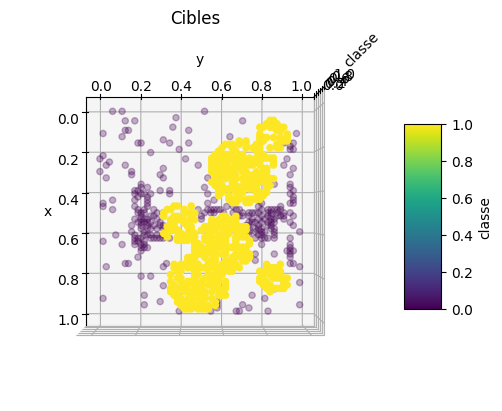

4


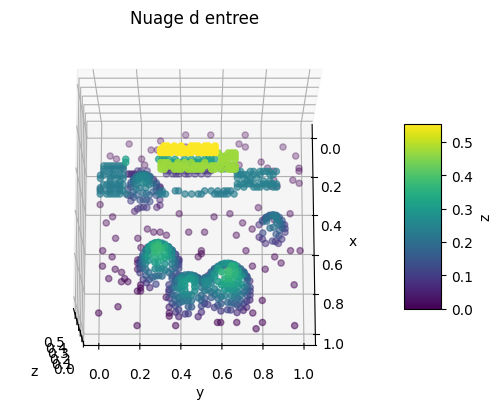

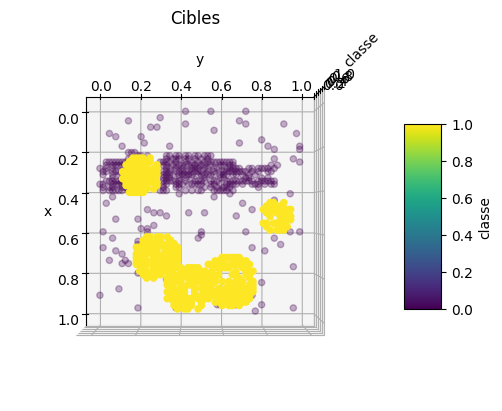

5


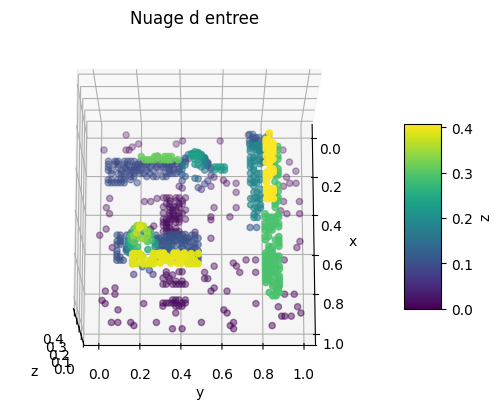

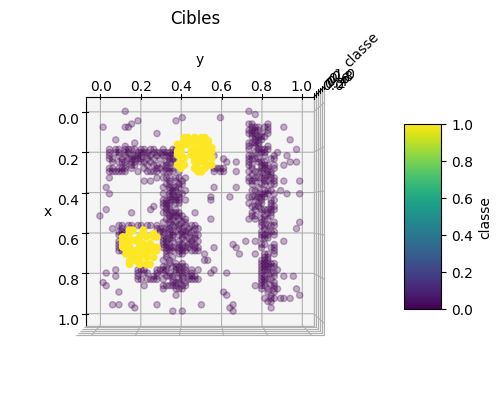

In [ ]:
batch_size = 6
input_points, target_list, target_points  = gen_pointcloud(batch_size)


for i in range(batch_size):
  print(i)
  # Représentation 3D des nuages de points et
  # les paramètres elev et azim permettent de changer l'angle de vue
  plot_triplets(input_points[i].transpose(0,1).cpu(),
                elev=75, azim=0)

  # Cibles : les points appartenant aux toitures d'igloos sont
  # dans la classe 1, les autres, dans la classe 0.
  plot_triplets(target_points[i].transpose(0,1).cpu(),
                title='Cibles',
                cbar_label='classe')

  # Note: target_points contient non seulement les classes
  # mais aussi les coordonnées x et y des points, pour
  # faciliter leur visualisation

In [ ]:
input_points.shape

torch.Size([6, 3, 800])

**Q1** A quoi correspondent les différentes dimensions de *input_points* ?

Les dimensions de input_points correspondent à :


*   6 -> la taille du batch, cad le nombre de nuages de points utilisés.
*   3 -> la dimension du problème, ici 3D
*   800 -> le nombre de points utilisés dans un nuage de points.

Ici 3 et 800 sortent dans cet ordre à cause de l'utilisation de "transpose"



**Q2** Les points d'un nuage sont-ils rangés dans un ordre particulier ?

In [ ]:
Non, il n'y a pas d'ordre particulier, par ailleurs on ne connaît pas à l'avance la position des objets étudiés.

**Q3** (question ouverte). Si vous deviez traiter le problème avec un FCN ou un ViT (Visual Transformer), que feriez-vous ?

Il faudrait adapter le format du nuages de points pour pouvoir l'utiliser dans un FCN (ViT on l'a vu ce matin je n'essaierais même pas). Pour pouvoir donner notre nuage, on pourrait le projeter en 2D pour avoir une image plus facilement exploitable pour un FCN et pouvoir segmenter l'image.

## Partie II : le modèle PointNet

Dans cette partie, on s'intéresse à la propriété principale d'un réseau PointNet : l'utilisation d'opérations invariantes par rapport à l'ordre dans lequel les points sont présentés au réseau.

In [ ]:
from utils_probleme2 import PointNetSegHead
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
output, _, _ = pointnet(input_points)

**Q1** La sortie du modèle PointNet correspond au premier tenseur du *tuple* fourni la fonction *forward* de *pointnet*. A quoi correspondent les différentes dimensions de *output* ? Quel est l'effet d'une permutation des points contenus dans *inputs_points* sur la sortie ? Répondre :

- en vous référant à l'article [l'article](https://arxiv.org/abs/1612.00593) qui introduit ce réseau (citer dans le texte).
- à partir de tests à effectuer dans la cellule de code suivante (utiliser torch.randperm pour générer des permutations sur les entrées)

D'après l'article la permutation n'a pas d'effet si l'on utilise uniquement des opérations symétriques (tel que + ou *)


"use a simple symmetric function to aggregate the information from each point. Here, a symmetric function takes n vectors as input and outputs a new vector that is invariant to the input order. For example, + and ∗ operators are symmetric binary functions"

Or ici c'est en pratique plus compliqué car il faut conserver la proximité spatiale des points.

"requiring that this map preserves spatial proximity as the dimension reduces"



In [ ]:
# Permute points
idx = torch.randperm(input_points.shape[1])
input_points_permuted = input_points[:, idx, :]
input_points_permuted = input_points_permuted.transpose(0, 1)
input_points_permuted = input_points_permuted.cuda()


# Get output after permutation
output_permuted, _, _ = pointnet(input_points_permuted)


# Compare outputs
diff = torch.abs(output - output_permuted[:, idx, :])
print(diff.max())

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


**Q2** L'architecture de *pointnet* est décrite dans la Figure 2 de l'article (voir ci-dessous) évoqué à la question précédente. En dehors des opérations notées "input transform" et "feature transform", dont la compréhension est plus délicate, quelles sont les différentes opérations conduisant à une segmentation ? Que signifie le terme "shared" et expliquer en quoi ces opérations sont invariantes par rapport à l'ordre de présentation des points.

*  Les étapes MLP représentent un réseau de neurones multicouches.
*  Le maxpooling est une opération pour réduire la dimension des tenseurs et garder les valeurs les plus fortes.
* Le terme "shared" signifie que les points en entrée sont partagés pour les neurones et de ce fait leur ordre n'importe pas.

<img src= https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lFnrIqmV_47iRvQcY3dB7Q.png >

## Partie III

Dans cette partie, on se propose d'entraîner un PointNet. Pour ce faire, on utilisera une fonction de coût spécifique (voir cellule ci-dessous).

**Consignes :**

1) Entraîner un PointNet sur quelques centaines d'époques.

2) Afficher à chaque époque la justesse des prédictions

3) Charger les poids d'un réseau entraîné sur 500 époques, stockés dans le fichier **pointnet_500_ep.pth** du répertoire https://huggingface.co/nanopiero/pointnet_igloos.

Visualiser les sorties de ce modèle-là en complétant le la dernière cellule de code du calepin.


J'ai téléchargé les poids sans utilisation fructueuse.

In [ ]:
optimizer = torch.optim.Adam(pointnet.parameters(),
                             lr=0.0001, betas=(0.9, 0.999))

# manually set alpha weights
alpha = np.array([0.2, 0.8])
gamma = 1
loss_fn = PointNetSegLoss(alpha=alpha, gamma=gamma, dice=True).cuda()

# exemple d'utilisation de PointNetSegLoss:
# La transposition permet de repasser la dimension relative
# aux probabilités en dernier, comme avec torch.nn.CrossEntropyLoss
proba_pred_list = outputs.transpose(1,2)
loss_fn(proba_pred_list, target_list)

NameError: name 'PointNetSegLoss' is not defined

In [ ]:
batch_size = 64
n_epochs = 200
n_batch_per_epoch = 10


for epoch in range(1, n_epochs):
  print('epoch : ', epoch)
  for batch in range(1,n_batch_per_epoch):
    input_points, target_list, _ = gen_pointcloud(batch_size)
    input_points = input_points.cuda()

epoch :  1


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
input_points, target_list , target_points = gen_pointcloud(6)

# Il faut construire les prédictions.
proba_pred_list, _, _ = pointnet2.cuda()(input_points.to(device))
pred_list = proba_pred_list.transpose(1,2).max(1)[1].cpu()

# Accuracy:
...
# Tracé

for i in range(6):
  print(i)
  plot_triplets(input_points[i].transpose(0,1), elev=75, azim=0)
  plot_triplets(target_points[i].transpose(0,1),
                title='Cibles',
                cbar_label='classe')
  plot_triplets(...,
                title='Predictions',
                cbar_label='classe')
